<a href="https://colab.research.google.com/github/bird0401/image_search/blob/main/metric_learning/TripletLoss_ContrastiveLoss_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pytorch-metric-learning[with-hooks]
!pip install umap-learn

     |████████████████████████████████| 109 kB 14.2 MB/s 
     |████████████████████████████████| 85.5 MB 105 kB/s 
     |████████████████████████████████| 88 kB 5.8 MB/s 
     |████████████████████████████████| 1.1 MB 34.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=48d30382a9adfa682ae8e5d65be4d8afe47193face17e95eaa14a4f455624bc3
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=a88b3e498380505c0f3e8ab9abb77a0935ca95ce73e0c686dba0bfb3366c8bdd
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [3]:
from torchvision import datasets, transforms

In [4]:
# mean and std should change depends on dataset
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,),std=(0.5,))
    ])

In [5]:
# downloaad Fashion MNIST dataset
data_path = "dataset"  # 任意の場所
train_dataset = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(data_path, train=False, transform=transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.fc = nn.Linear(18432, 1152)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = F.relu(x)
        x = self.dropout2(x)
        return x

class Embedder(nn.Module):
    def __init__(self):
        super(Embedder, self).__init__()
        self.fc = nn.Linear(1152, 128)
     
    def forward(self, x):
        x = self.fc(x)
        return x 

In [12]:
# Triplet loss
from pytorch_metric_learning import losses, miners, distances, reducers, samplers

distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
# loss = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
loss = losses.ContrastiveLoss(pos_margin=0, neg_margin=1)
miner = miners.TripletMarginMiner(margin=0.2, distance=distance, type_of_triplets="semihard")
sampler = samplers.MPerClassSampler(train_dataset.targets, m=4,
                                    length_before_new_iter=len(train_dataset))

loss_funcs = {"metric_loss": loss}
mining_funcs = {"tuple_miner": miner}

In [13]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
import umap
from cycler import cycler
from torch import optim
from pytorch_metric_learning import trainers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.utils import logging_presets

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルをロード
trunk = Net()
trunk = torch.nn.DataParallel(trunk.to(device))
embedder = Embedder()
embedder = torch.nn.DataParallel(embedder.to(device))
models = {"trunk": trunk, "embedder": embedder}

# Optimizerの設定
trunk_optimizer = optim.Adam(trunk.parameters(), lr=0.005)
embedder_optimizer = optim.Adam(embedder.parameters(), lr=0.001)
optimizers = {"trunk_optimizer": trunk_optimizer,
              "embedder_optimizer": embedder_optimizer}

# 可視化用のvisual_hookの実装
record_keeper, _, _ = logging_presets.get_record_keeper("logs", "tensorboard")
hooks = logging_presets.get_hook_container(record_keeper)

def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname, epoch):
    class_labels = np.unique(labels)
    num_classes = len(class_labels)
    
    fig = plt.figure(figsize=(8, 6))
    colors = [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]
    plt.gca().set_prop_cycle(cycler("color", colors))

    for i, lab in enumerate(class_labels):
        idx = labels == class_labels[i]
        plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=3, label=lab) 

    plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    os.makedirs("result", exist_ok=True)
    plt.savefig(f"result/{epoch:02d}.png")
    plt.show()
    plt.close()

# Testerの設定
tester = testers.GlobalEmbeddingSpaceTester(end_of_testing_hook=hooks.end_of_testing_hook, 
                                            visualizer=umap.UMAP(), 
                                            visualizer_hook=visualizer_hook,
                                            dataloader_num_workers=4)

# Hookの設定
dataset_dict = {"val": test_dataset}
model_dir = "saved_models"
end_of_epoch_hook = hooks.end_of_epoch_hook(tester, 
                                            dataset_dict, 
                                            model_dir, 
                                            test_interval=1,
                                            patience=1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/234 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 313/313 [00:02<0

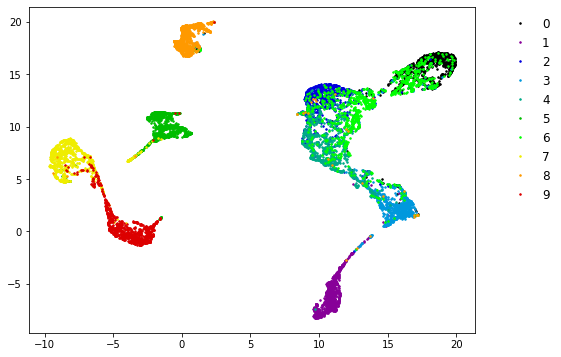

Using CPU for k-nn search because k = 10000 > 2048, which is the maximum allowable on GPU.
  0%|          | 0/234 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch di

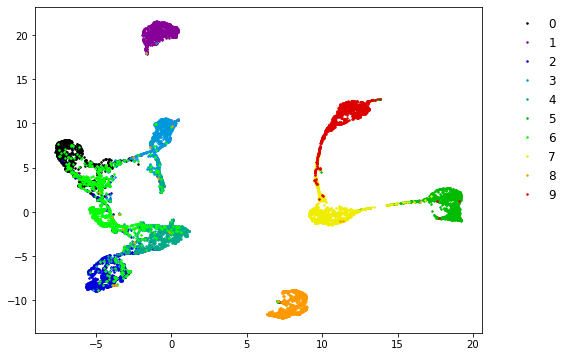

Using CPU for k-nn search because k = 10000 > 2048, which is the maximum allowable on GPU.
  0%|          | 0/234 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch di

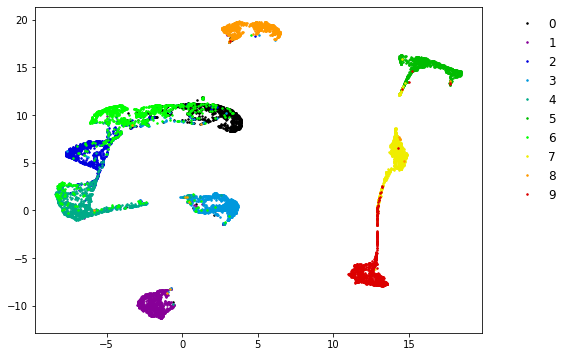

Using CPU for k-nn search because k = 10000 > 2048, which is the maximum allowable on GPU.
  0%|          | 0/234 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch di

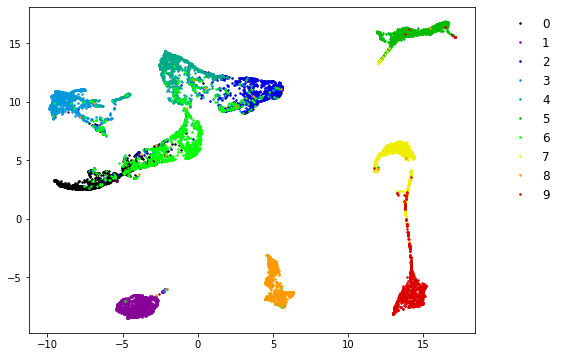

Using CPU for k-nn search because k = 10000 > 2048, which is the maximum allowable on GPU.
  0%|          | 0/234 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch di

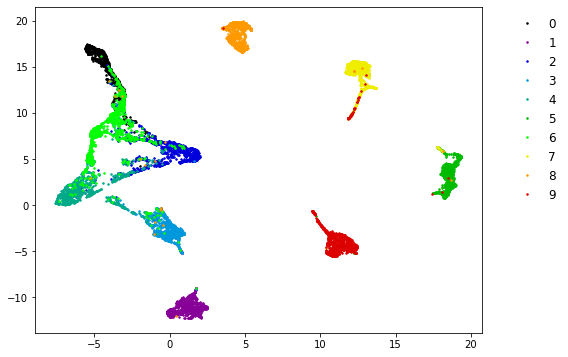

Using CPU for k-nn search because k = 10000 > 2048, which is the maximum allowable on GPU.


In [11]:
# モデル訓練
num_epochs = 5
batch_size = 256

trainer = trainers.MetricLossOnly(models,
                                  optimizers,
                                  batch_size,
                                  loss_funcs,
                                  mining_funcs,
                                  train_dataset,
                                  sampler=sampler,
                                  dataloader_num_workers=4,
                                  end_of_iteration_hook=hooks.end_of_iteration_hook,
                                  end_of_epoch_hook=end_of_epoch_hook)
trainer.train(num_epochs=num_epochs)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/234 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 313/313 [00:03<0

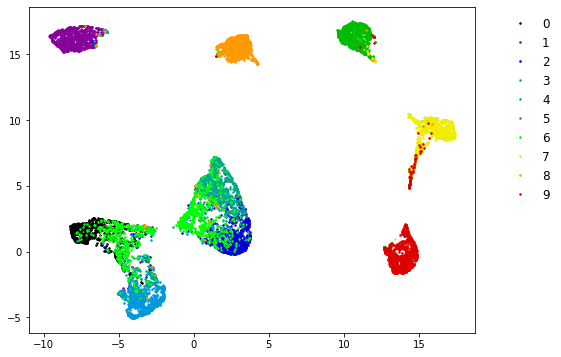

Using CPU for k-nn search because k = 10000 > 2048, which is the maximum allowable on GPU.
  0%|          | 0/234 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch di

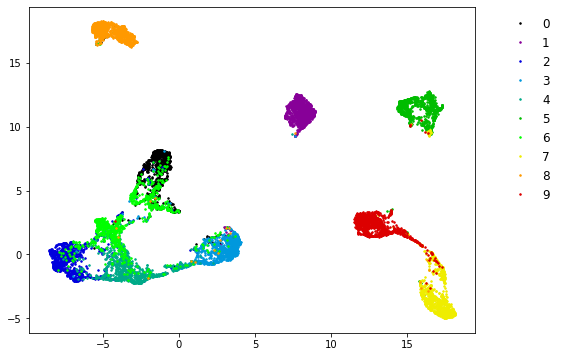

Using CPU for k-nn search because k = 10000 > 2048, which is the maximum allowable on GPU.
  0%|          | 0/234 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch di

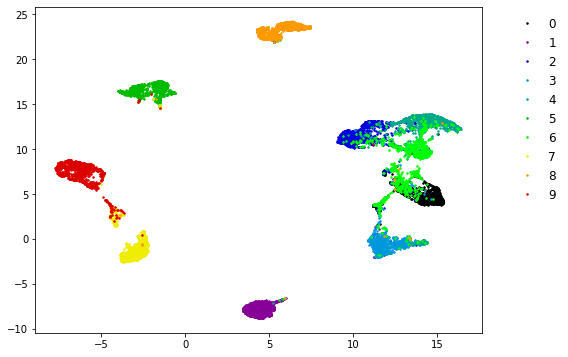

Using CPU for k-nn search because k = 10000 > 2048, which is the maximum allowable on GPU.
  0%|          | 0/234 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch di

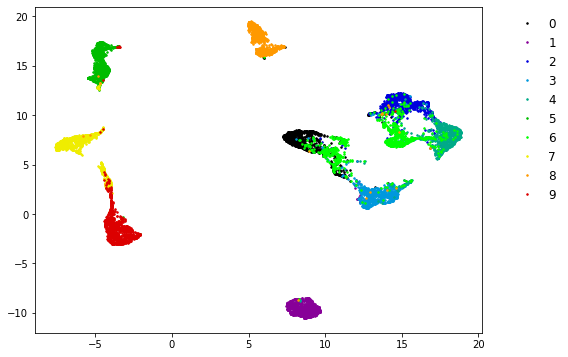

Using CPU for k-nn search because k = 10000 > 2048, which is the maximum allowable on GPU.
  0%|          | 0/234 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch di

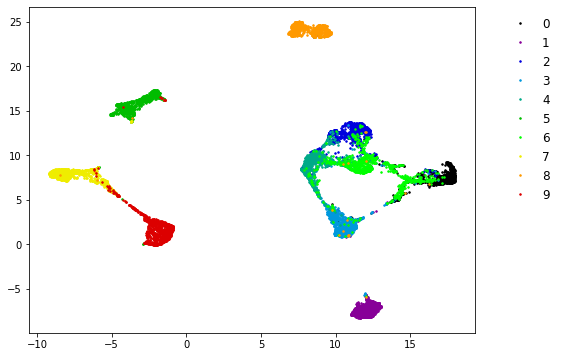

Using CPU for k-nn search because k = 10000 > 2048, which is the maximum allowable on GPU.


In [15]:
# モデル訓練
num_epochs = 5
batch_size = 256

trainer = trainers.MetricLossOnly(models,
                                  optimizers,
                                  batch_size,
                                  loss_funcs,
                                  mining_funcs,
                                  train_dataset,
                                  sampler=sampler,
                                  dataloader_num_workers=4,
                                  end_of_iteration_hook=hooks.end_of_iteration_hook,
                                  end_of_epoch_hook=end_of_epoch_hook)
trainer.train(num_epochs=num_epochs)